In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['text.color'] = '#FF1493'
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import cv2
import os
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
#from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import VGG16

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.listdir('/content/drive/MyDrive/Bhagyasree')

Mounted at /content/drive


['train', 'val']

In [ ]:
data_dir = '/content/drive/MyDrive/Bhagyasree'
train_dir = os.path.join(data_dir,"train/")
test_dir = os.path.join(data_dir,"val/")
labels=['Tomato___Septoria_leaf_spot',
 'Tomato___Bacterial_spot',
 'Tomato___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Late_blight',
 'Tomato___Early_blight',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Target_Spot',
 'Tomato___Leaf_Mold',
 'Tomato___Spider_mites Two-spotted_spider_mite']
numclass=len(labels)
print("Total Data Labels: ",numclass)

Total Data Labels:  10


In [ ]:
dirs=os.listdir(data_dir)
tot=0
for i in dirs:
    presdir=os.path.join(data_dir ,i)
    print("{}  contains {} databases".format(i,len(os.listdir(presdir))))
    tot+=len(os.listdir(presdir))

train  contains 10 databases
val  contains 10 databases


In [ ]:
train_data = []
for defects_id, sp in enumerate(labels):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

File  ...                                   Disease Type
9995  Tomato___Spider_mites Two-spotted_spider_mite/...  ...  Tomato___Spider_mites Two-spotted_spider_mite
9996  Tomato___Spider_mites Two-spotted_spider_mite/...  ...  Tomato___Spider_mites Two-spotted_spider_mite
9997  Tomato___Spider_mites Two-spotted_spider_mite/...  ...  Tomato___Spider_mites Two-spotted_spider_mite
9998  Tomato___Spider_mites Two-spotted_spider_mite/...  ...  Tomato___Spider_mites Two-spotted_spider_mite
9999  Tomato___Spider_mites Two-spotted_spider_mite/...  ...  Tomato___Spider_mites Two-spotted_spider_mite

[5 rows x 3 columns]

In [ ]:
train = train.sample(frac=1, random_state=42) 
train.index = np.arange(len(train)) # Reset indices
train.head()

File  ...                  Disease Type
0  Tomato___Tomato_mosaic_virus/b8a9c9dd-fbba-41e...  ...  Tomato___Tomato_mosaic_virus
1  Tomato___Late_blight/1430346f-f3f2-4766-bd0e-c...  ...          Tomato___Late_blight
2  Tomato___Bacterial_spot/e601dd19-754a-4db4-926...  ...       Tomato___Bacterial_spot
3  Tomato___Late_blight/c92709f9-fb16-4c49-8651-8...  ...          Tomato___Late_blight
4  Tomato___Late_blight/c933cfb7-d1c7-420b-88d0-7...  ...          Tomato___Late_blight

[5 rows x 3 columns]

In [ ]:
val_data = []
for defects_id, sp in enumerate(labels):
    for file in os.listdir(os.path.join(test_dir, sp)):
        val_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
val = pd.DataFrame(val_data, columns=['File', 'DiseaseID','Disease Type'])
val.tail()

File  ...                                   Disease Type
995  Tomato___Spider_mites Two-spotted_spider_mite/...  ...  Tomato___Spider_mites Two-spotted_spider_mite
996  Tomato___Spider_mites Two-spotted_spider_mite/...  ...  Tomato___Spider_mites Two-spotted_spider_mite
997  Tomato___Spider_mites Two-spotted_spider_mite/...  ...  Tomato___Spider_mites Two-spotted_spider_mite
998  Tomato___Spider_mites Two-spotted_spider_mite/...  ...  Tomato___Spider_mites Two-spotted_spider_mite
999  Tomato___Spider_mites Two-spotted_spider_mite/...  ...  Tomato___Spider_mites Two-spotted_spider_mite

[5 rows x 3 columns]

In [ ]:
val = val.sample(frac=1, random_state=42) 
val.index = np.arange(len(val)) # Reset indices
val.head()

File  ...                  Disease Type
0  Tomato___Early_blight/Tomato___Early_blight_or...  ...         Tomato___Early_blight
1  Tomato___Target_Spot/0b126ce6-af82-477f-8f4e-1...  ...          Tomato___Target_Spot
2  Tomato___Target_Spot/Tomato___Target_Spot_orig...  ...          Tomato___Target_Spot
3  Tomato___Tomato_mosaic_virus/0c779116-043c-471...  ...  Tomato___Tomato_mosaic_virus
4  Tomato___Late_blight/1ab30bde-88a4-4e29-855e-f...  ...          Tomato___Late_blight

[5 rows x 3 columns]

In [ ]:
dirs=os.listdir(train_dir)
labels=[]
cnts=[]
tot=0
for i in dirs:
    presdir=os.path.join(train_dir,i)
    print("Label Type: {} => Total Images: {} image files.".format(i,len(os.listdir(presdir))))
    tot+=len(os.listdir(presdir))
    labels.append(i)
    cnts.append(len(os.listdir(presdir)))
print("\nTotal images in the train database: ",tot)


Label Type: Tomato___Septoria_leaf_spot => Total Images: 1000 image files.
Label Type: Tomato___Bacterial_spot => Total Images: 1000 image files.
Label Type: Tomato___healthy => Total Images: 1000 image files.
Label Type: Tomato___Tomato_Yellow_Leaf_Curl_Virus => Total Images: 1000 image files.
Label Type: Tomato___Late_blight => Total Images: 1000 image files.
Label Type: Tomato___Early_blight => Total Images: 1000 image files.
Label Type: Tomato___Tomato_mosaic_virus => Total Images: 1000 image files.
Label Type: Tomato___Target_Spot => Total Images: 1000 image files.
Label Type: Tomato___Leaf_Mold => Total Images: 1000 image files.
Label Type: Tomato___Spider_mites Two-spotted_spider_mite => Total Images: 1000 image files.

Total images in the train database:  10000


In [ ]:
dirs=os.listdir(test_dir)
labels=[]
cnts=[]
tot=0
for i in dirs:
    presdir=os.path.join(test_dir,i)
    print("Label Type: {} => Total Images: {} image files.".format(i,len(os.listdir(presdir))))
    tot+=len(os.listdir(presdir))
    labels.append(i)
    cnts.append(len(os.listdir(presdir)))
print("\nTotal images in the test database: ",tot)

Label Type: Tomato___Early_blight => Total Images: 100 image files.
Label Type: Tomato___healthy => Total Images: 100 image files.
Label Type: Tomato___Septoria_leaf_spot => Total Images: 100 image files.
Label Type: Tomato___Leaf_Mold => Total Images: 100 image files.
Label Type: Tomato___Target_Spot => Total Images: 100 image files.
Label Type: Tomato___Bacterial_spot => Total Images: 100 image files.
Label Type: Tomato___Late_blight => Total Images: 100 image files.
Label Type: Tomato___Tomato_mosaic_virus => Total Images: 100 image files.
Label Type: Tomato___Spider_mites Two-spotted_spider_mite => Total Images: 100 image files.
Label Type: Tomato___Tomato_Yellow_Leaf_Curl_Virus => Total Images: 100 image files.

Total images in the test database:  1000


In [ ]:
diseasetype=train['Disease Type'].value_counts().index.tolist()
print(diseasetype)
cnt=train['Disease Type'].value_counts().tolist()
dssdf=pd.DataFrame({"Type":diseasetype,"Count":cnt})
fig = px.bar(dssdf, x="Type", y="Count",
             text="Count",color="Type",
             title="Count of Labels in Databse",height=700,width=1400)
fig.update_layout(
        font=dict(
            family="Times New Roman, Bold",
            size=20,
            color="dodgerblue"
        )
    )
fig.show()


['Tomato___Leaf_Mold', 'Tomato___Late_blight', 'Tomato___Bacterial_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___Target_Spot', 'Tomato___Early_blight', 'Tomato___healthy']


In [ ]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

File  ...             Disease Type
0  Tomato___Target_Spot/613ecdcf-3895-498b-b095-7...  ...     Tomato___Target_Spot
1  Tomato___Leaf_Mold/db0e6ad7-58db-478e-9b17-37b...  ...       Tomato___Leaf_Mold
2  Tomato___Late_blight/e20107e7-137f-400e-817f-5...  ...     Tomato___Late_blight
3  Tomato___Early_blight/5ac54e63-40a4-4651-a900-...  ...    Tomato___Early_blight
4  Tomato___Bacterial_spot/b72055e8-e855-4c88-a6b...  ...  Tomato___Bacterial_spot

[5 rows x 3 columns]

In [ ]:
allacc,allloss=[],[]

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.3)
# Training and validation dataset
train = datagen.flow_from_directory(train_dir, seed=123, subset='training')
val = datagen.flow_from_directory(test_dir, seed=123, subset='validation')

# Test dataset for evaluation
datagen2 = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test = datagen2.flow_from_directory(test_dir)

Found 7000 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [ ]:
def build_resnet():
    base_model = ResNet152V2(input_shape=(256,256,3), include_top=False)
    
    for layers in base_model.layers[:140]:
        layers.trainable = False
    for layers in base_model.layers[140:]:
        layers.trainable = True
        
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred = Dense(10, activation='softmax')(x)
    
    modelres = Model(inputs=base_model.input, outputs=pred)
    return modelres

In [ ]:
modelres = build_resnet()
modelres.summary()
modelres.compile(loss='categorical_crossentropy', optimizer='sgd', metrics='accuracy')
histres=modelres.fit(train, batch_size=80, epochs=5, validation_data=val)

234561536/234545216 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
___________________________

In [ ]:
train_acc = histres.history['accuracy']
test_acc = histres.history['val_accuracy']
train_loss = histres.history['loss']
test_loss = histres.history['val_loss']
model_stat1=pd.DataFrame({
    "Epoch":[i+1 for i in range(5)],
    "Training Loss":train_loss,
    "Test Loss":test_loss,
    "Training Accuracy":train_acc,
    "Test Accuracy":test_acc
})
model_stat1.to_csv("model_resnet152v2.csv")
model_stat1

Epoch  Training Loss  Test Loss  Training Accuracy  Test Accuracy
0      1       0.634491   0.259827           0.808571       0.926667
1      2       0.077588   0.124065           0.978714       0.960000
2      3       0.027832   0.108618           0.994000       0.960000
3      4       0.015390   0.102912           0.996286       0.963333
4      5       0.011857   0.088896           0.996857       0.966667

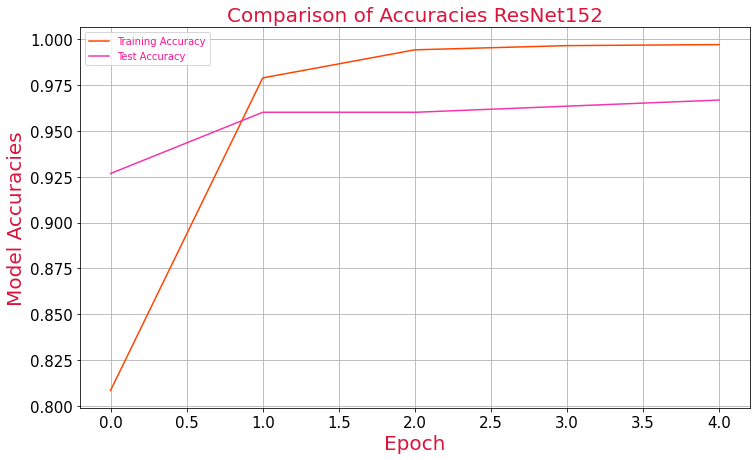

In [ ]:
collist=["#FF4500","#F535AA"]
model_stat1.iloc[:,3:].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Accuracies ResNet152",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Accuracies",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

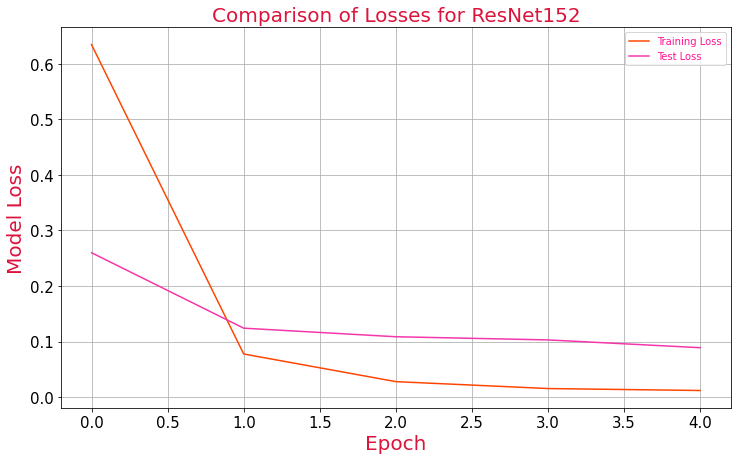

In [ ]:
model_stat1.iloc[:,1:3].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Losses for ResNet152",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Loss",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

In [ ]:
final_lossres152, final_accuracyres152 = modelres.evaluate(test)
print('Final Loss(ResNet152): {}\n Final Accuracy(ResNet152): {}'.format(final_lossres152, final_accuracyres152))
allacc.append(round(final_accuracyres152,4)*100)
allloss.append(round(final_lossres152,4)*100)

32/32 [==============================] - 18s 569ms/step - loss: 0.1578 - accuracy: 0.9460
Final Loss(ResNet152): 0.1577705442905426
 Final Accuracy(ResNet152): 0.9459999799728394


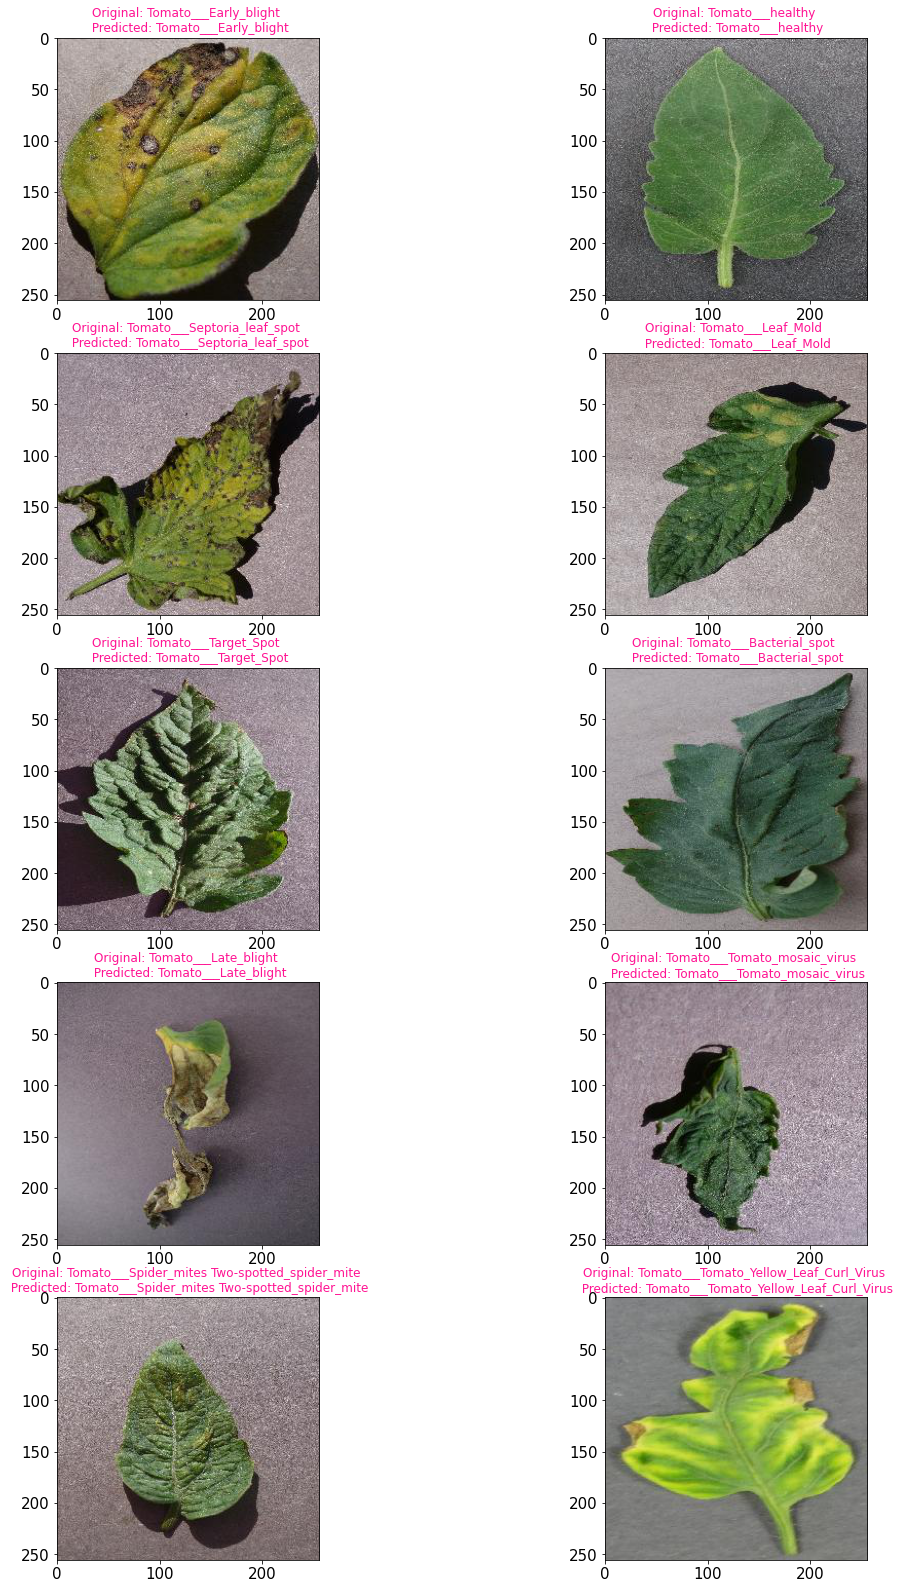

In [ ]:
classes = os.listdir(data_dir+"/"+"val/")

plt.figure(figsize=(18,28))

for i in enumerate(classes):
    pic = os.listdir(data_dir+"/"+"val/"+i[1])
    pic = pic[np.random.randint(len(pic)-1)]
    image = Image.open(data_dir+"/"+"val/"+i[1]+'/'+pic)
    image = np.asarray(image)
    
    pred = np.argmax(modelres.predict(image.reshape(-1,256,256,3)/255))
    for j in list(enumerate(list(test.class_indices.keys()))):
        if pred == j[0]:
            prediction =  j[1]
    
    plt.subplot(5,2,i[0]+1)
    plt.title('Original: {} \n Predicted: {}'.format(i[1], prediction))
    plt.imshow(image)
plt.show()

In [ ]:
def build_resnet50():
    base_model = ResNet50(input_shape=(256,256,3), include_top=False)
    
    for layers in base_model.layers[:140]:
        layers.trainable = False
    for layers in base_model.layers[140:]:
        layers.trainable = True
        
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred = Dense(10, activation='softmax')(x)
    
    modelres50 = Model(inputs=base_model.input, outputs=pred)
    return modelres50

In [ ]:
modelres50 = build_resnet50()
modelres50.summary()
modelres50.compile(loss='categorical_crossentropy', optimizer='sgd', metrics='accuracy')
histres50=modelres50.fit(train, batch_size=80, epochs=5, validation_data=val)


94781440/94765736 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________

In [ ]:
train_acc = histres50.history['accuracy']
test_acc = histres50.history['val_accuracy']
train_loss = histres50.history['loss']
test_loss = histres50.history['val_loss']
model_stat2=pd.DataFrame({
    "Epoch":[i+1 for i in range(5)],
    "Training Loss":train_loss,
    "Test Loss":test_loss,
    "Training Accuracy":train_acc,
    "Test Accuracy":test_acc
})
model_stat2.to_csv("model_resnet50.csv")
model_stat2

Epoch  Training Loss  Test Loss  Training Accuracy  Test Accuracy
0      1       1.456491   3.313242           0.479571       0.103333
1      2       1.021450   5.635304           0.638429       0.196667
2      3       0.900664   2.511787           0.683429       0.370000
3      4       0.807550   4.574394           0.712857       0.270000
4      5       0.732171   3.120719           0.746143       0.360000

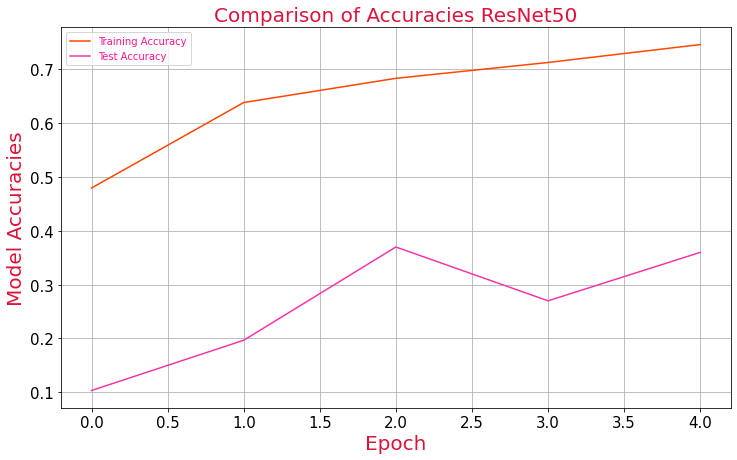

In [ ]:
collist=["#FF4500","#F535AA"]
model_stat2.iloc[:,3:].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Accuracies ResNet50",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Accuracies",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

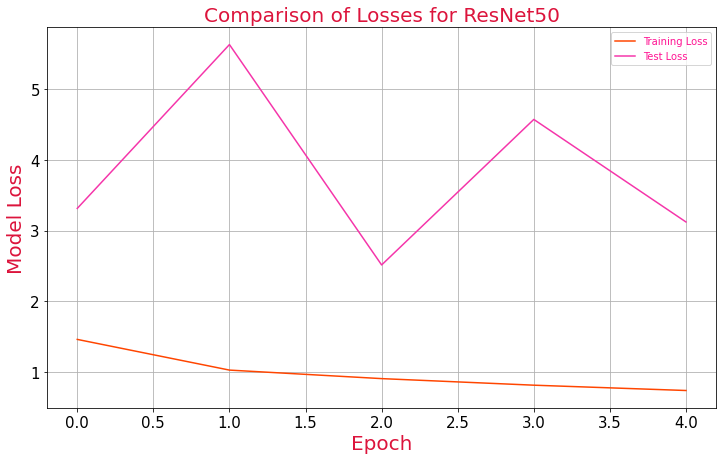

In [ ]:
model_stat2.iloc[:,1:3].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Losses for ResNet50",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Loss",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

In [ ]:
final_lossres50, final_accuracyres50 = modelres50.evaluate(test)
print('Final Loss(ResNet50): {}\nFinal Accuracy(ResNet50): {}'.format(final_lossres50, final_accuracyres50))
allacc.append(round(final_accuracyres50,4)*100)
allloss.append(round(final_lossres50,4)*100)

32/32 [==============================] - 9s 263ms/step - loss: 3.2683 - accuracy: 0.3370
Final Loss(ResNet50): 3.2683165073394775
Final Accuracy(ResNet50): 0.3370000123977661


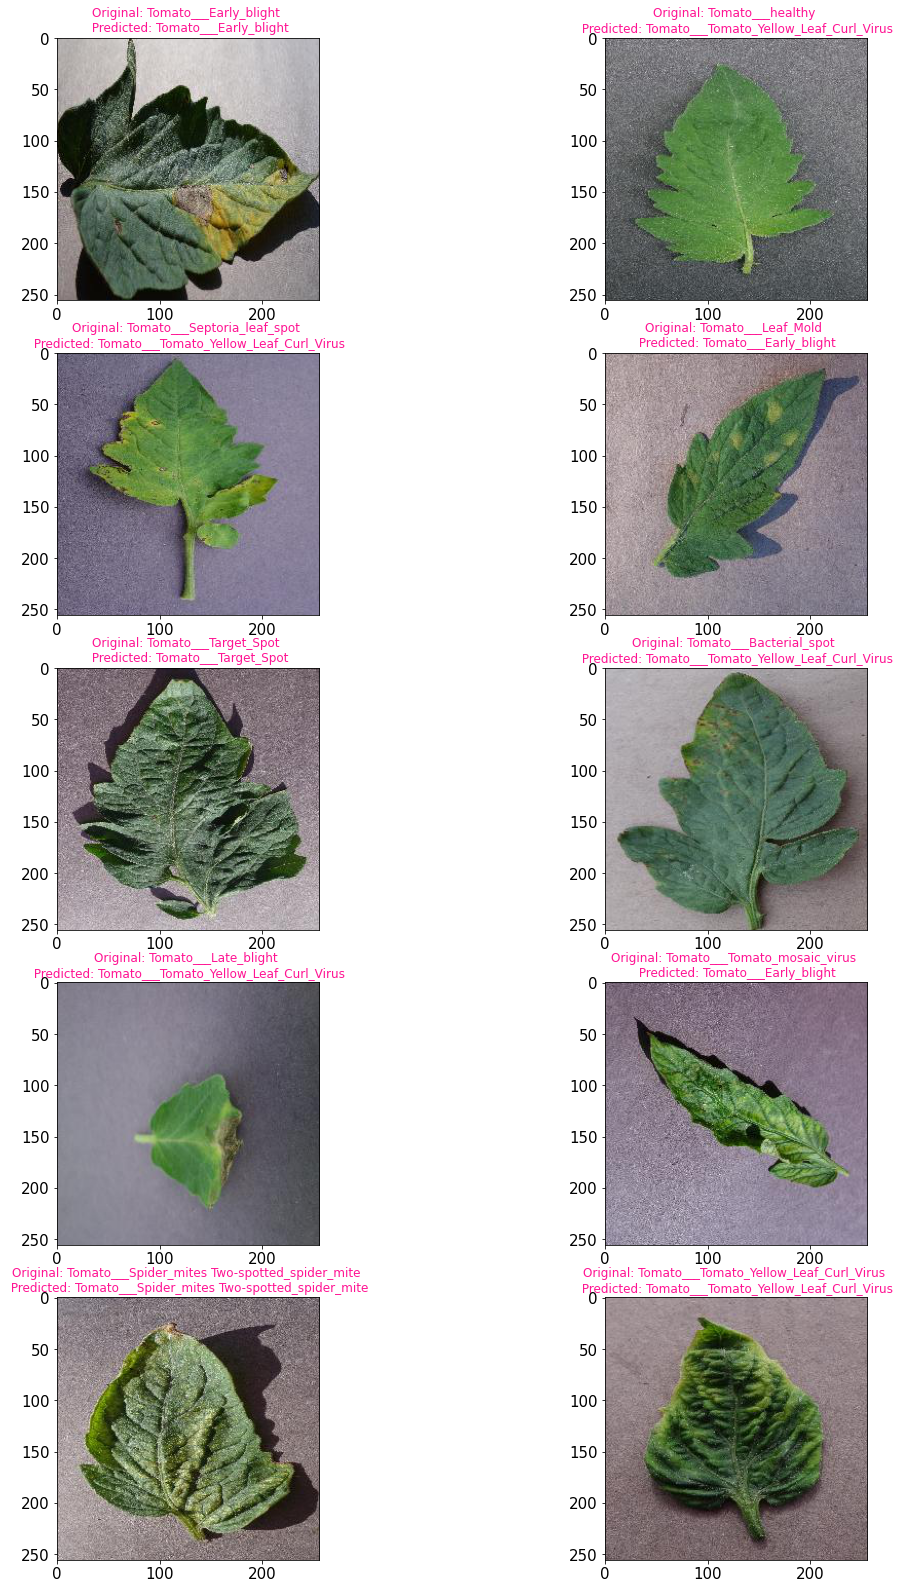

In [ ]:
classes = os.listdir(data_dir+"/"+"val/")

plt.figure(figsize=(18,28))

for i in enumerate(classes):
    pic = os.listdir(data_dir+"/"+"val/"+i[1])
    pic = pic[np.random.randint(len(pic)-1)]
    image = Image.open(data_dir+"/"+"val/"+i[1]+'/'+pic)
    image = np.asarray(image)
    
    pred = np.argmax(modelres50.predict(image.reshape(-1,256,256,3)/255))
    for j in list(enumerate(list(test.class_indices.keys()))):
        if pred == j[0]:
            prediction =  j[1]
    
    plt.subplot(5,2,i[0]+1)
    plt.title('Original: {} \n Predicted: {}'.format(i[1], prediction))
    plt.imshow(image)
plt.show()

In [ ]:
def build_densenet():
    base_model = DenseNet121(input_shape=(256,256,3), include_top=False)
    
    for layers in base_model.layers[:140]:
        layers.trainable = False
    for layers in base_model.layers[140:]:
        layers.trainable = True
        
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred = Dense(10, activation='softmax')(x)
    
    modelden = Model(inputs=base_model.input, outputs=pred)
    return modelden

In [ ]:
modelden = build_resnet()
modelden.summary()
modelden.compile(loss='categorical_crossentropy', optimizer='sgd', metrics='accuracy')
histden=modelden.fit(train, batch_size=80, epochs=5, validation_data=val)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
train_acc = histden.history['accuracy']
test_acc = histden.history['val_accuracy']
train_loss = histden.history['loss']
test_loss = histden.history['val_loss']
model_stat3=pd.DataFrame({
    "Epoch":[i+1 for i in range(5)],
    "Training Loss":train_loss,
    "Test Loss":test_loss,
    "Training Accuracy":train_acc,
    "Test Accuracy":test_acc
})
model_stat3.to_csv("model_densenet.csv")
model_stat3

Epoch  Training Loss  Test Loss  Training Accuracy  Test Accuracy
0      1       0.621579   0.248642           0.811143       0.903333
1      2       0.084365   0.112825           0.976429       0.963333
2      3       0.026747   0.075844           0.993429       0.970000
3      4       0.013251   0.066819           0.997429       0.983333
4      5       0.006031   0.053595           0.999571       0.983333

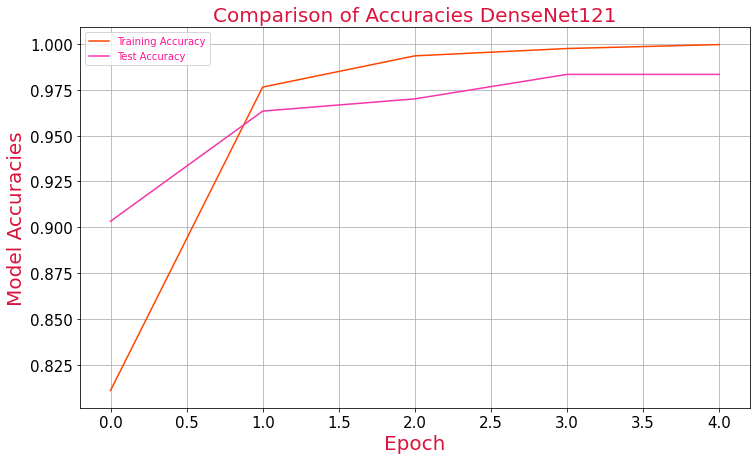

In [ ]:
collist=["#FF4500","#F535AA"]
model_stat3.iloc[:,3:].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Accuracies DenseNet121",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Accuracies",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

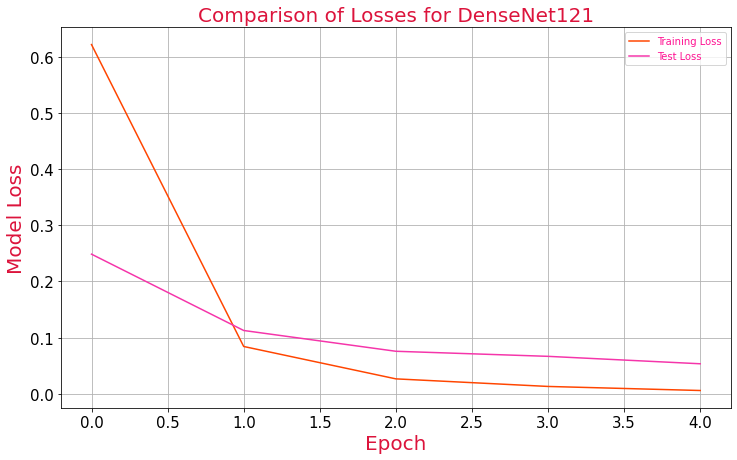

In [ ]:
model_stat3.iloc[:,1:3].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Losses for DenseNet121",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Loss",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

In [ ]:
final_lossden, final_accuracyden = modelden.evaluate(test)
print('Final Loss(DenseNet121): {}\nFinal Accuracy(DenseNet121): {}'.format(final_lossden, final_accuracyden))
allacc.append(round(final_accuracyden,4)*100)
allloss.append(round(final_lossden,4)*100)

32/32 [==============================] - 19s 572ms/step - loss: 0.1379 - accuracy: 0.9560
Final Loss(DenseNet121): 0.13787797093391418
Final Accuracy(DenseNet121): 0.9559999704360962


In [ ]:
classes = os.listdir(data_dir+"/"+"val/")

plt.figure(figsize=(18,28))

for i in enumerate(classes):
    pic = os.listdir(data_dir+"/"+"val/"+i[1])
    pic = pic[np.random.randint(len(pic)-1)]
    image = Image.open(data_dir+"/"+"val/"+i[1]+'/'+pic)
    image = np.asarray(image)
    
    pred = np.argmax(modelden.predict(image.reshape(-1,256,256,3)/255))
    for j in list(enumerate(list(test.class_indices.keys()))):
        if pred == j[0]:
            prediction =  j[1]
    
    plt.subplot(5,2,i[0]+1)
    plt.title('Original: {} \n Predicted: {}'.format(i[1], prediction))
    plt.imshow(image)
plt.show()

In [ ]:
models=['ResNet152','ResNet50','DenseNet121']
accdf=pd.DataFrame({"Model":models,"Accuracies":allacc,"Loss":allloss})
accdf=accdf.sort_values(by="Accuracies",ascending=False)
accdf
for i in accdf.columns.tolist()[1:]:
    accout=accdf.sort_values(by=i,ascending=False)
    fig = px.bar(accout, y=i, x="Model",color="Model",text=i,title="Comparison of {}".format(i),width=700)
    fig.update_layout(
        font=dict(
            family="Times New Roman, Bold",
            size=20,
            color="black"
        )
    )
    fig.show()

In [ ]:
accdf

Model  Accuracies    Loss
2  DenseNet121        95.6   13.79
0    ResNet152        94.6   15.78
1     ResNet50        33.7  326.83